<a href="https://colab.research.google.com/github/harry9879/Neural-network-with-attention-and-transformer/blob/main/eng_to_fre/Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.5 MB/s eta 0:00:00


In [ ]:
pip install tensorflow_text

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [ ]:
import matplotlib.pyplot as plt
import einops

In [ ]:
import tensorflow_text as tf_text

In [ ]:
dataset = pd.read_csv('small_file_0.csv')

In [ ]:
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [ ]:
eng_dataset = dataset['en'].to_numpy()
fre_dataset = dataset['fr'].to_numpy()

In [ ]:
eng_dataset = [str(data).encode() for data in eng_dataset]
fre_dataset = [str(data).encode() for data in fre_dataset]

In [ ]:
eng_dataset = tf.constant(eng_dataset)
fre_dataset = tf.constant(fre_dataset)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000

dataset_size = len(dataset)

train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size


In [ ]:
BUFFER_SIZE = len(fre_dataset)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(eng_dataset),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((fre_dataset[is_train], eng_dataset[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((fre_dataset[~is_train], eng_dataset[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))


In [ ]:
def tf_lower_and_split_punct(text):
    
  text = tf_text.normalize_utf8(text, 'NFKD')
  
  text = tf.strings.lower(text)

  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')

  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')

  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [ ]:
max_vocab_size = 10000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize= tf_lower_and_split_punct,
    max_tokens = max_vocab_size,
    ragged = True
)

In [ ]:
context_text_processor.adapt(train_raw.map(lambda x,y : x))
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', 'de', ',', '.', '[START]', '[END]', 'et', 'la', 'les']

In [ ]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda x,y: y))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '.', ',', '[START]', '[END]', 'the', 'and', 'of', 'in']

In [ ]:
context_text_processor.adapt(train_raw.map(lambda x,y : x))
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', 'de', ',', '.', '[START]', '[END]', 'et', 'la', 'les']

In [ ]:
example_sentence = tf.constant(['Ce groupe est coprésidé par le ministre du Commerce international et le vice-premier ministre russe responsable de l’économie.'])

In [ ]:
example_tokens = context_text_processor(example_sentence)

In [ ]:
def process_text(context, target):
    context = context_text_processor(context).to_tensor()
    target = target_text_processor(target)
    targ_in = target[:, :-1].to_tensor()
    targ_out = target[:, 1:].to_tensor()
    return (context, targ_in), targ_out

train_ds =  train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [ ]:
for (ex_context_tok , ex_tar_in), ex_tar_out in train_ds.take(1):
    print(ex_context_tok[0,:10].numpy())
    print()
    print(ex_tar_in[0,:10].numpy())
    print(ex_tar_out[0,:10].numpy())

[   5   59  114  334    2  374   21 1774    7  906]

[   4   48   19 1382    7  220   10    6 9921   14]
[  48   19 1382    7  220   10    6 9921   14  461]


In [ ]:
UNITS = 256

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, text_processor, units):
        super(Encoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.units = units
        
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, units, mask_zero = True)
        
        self.rnn = tf.keras.layers.Bidirectional(
            merge_mode='sum',
            layer =tf.keras.layers.GRU(units,
                                       return_sequences=True,
                                       recurrent_initializer='glorot_uniform'))
    def call(self,x):
        shape_checker = ShapeChecker()
        shape_checker(x, 'batch s')
        
        x = self.embedding(x)
        shape_checker(x, 'batch s units')
        
        x = self.rnn(x)
        shape_checker(x, 'batch s units')
        
        return x
    
    def convert_input(self, texts):
        texts = tf.convert_to_tensor(texts)
        if len(texts.shape) == 0:
            texts = tf.convert_to_tensor(texts)[tf.newaxis]
        context = self.text_processor(texts).to_tensor()
        context = self(context)
        
        return context

In [ ]:
encoder = Encoder(context_text_processor, UNITS)
ex_context  = encoder(ex_context_tok)
print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Context tokens, shape (batch, s, unit): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 74)
Context tokens, shape (batch, s, unit): (64, 74, 256)


In [ ]:
ex_context_tok[1]

<tf.Tensor: shape=(74,), dtype=int64, numpy=
array([   5, 1048,  339,    1,   22,   18,   13,   53,  715,    7,    2,
        725,    3,  103,  547,  130,    1,   26,    2,    8,  144,  467,
          4,    6,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0])>

In [ ]:
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(key_dim = units , num_heads=1, **kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()
    
    def call(self, x, context):
        shape_checker = ShapeChecker()
        
        shape_checker(x, 'batch t units')
        shape_checker(context, 'batch s units')
        
        attn_output, attn_scores = self.mha(
            query = x,
            value = context,
            return_attention_scores = True
        )
        shape_checker(x, 'batch t units')
        shape_checker(attn_scores, 'batch heads t s' )
        
        #Cache the attention scores for plotting later.
        attn_scores = tf.reduce_mean(attn_scores, axis = 1)
        shape_checker(attn_scores, 'batch t s')
        self.last_attention_weights = attn_scores
        
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        
        return x      

In [ ]:
attention_layer = CrossAttention(UNITS)

embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(), output_dim=UNITS, mask_zero = True)

ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 74, 256)
Target sequence, shape (batch, t, units): (64, 49, 256)
Attention result, shape (batch, t, units): (64, 49, 256)
Attention weights, shape (batch, t, s):    (64, 49, 74)


In [ ]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.        , 1.        , 1.        , 0.99999994, 0.99999994,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.99999994, 1.        , 0.99999994, 1.0000001 , 1.        ,
       1.0000001 , 1.        , 1.0000001 , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        ], dtype=float32)

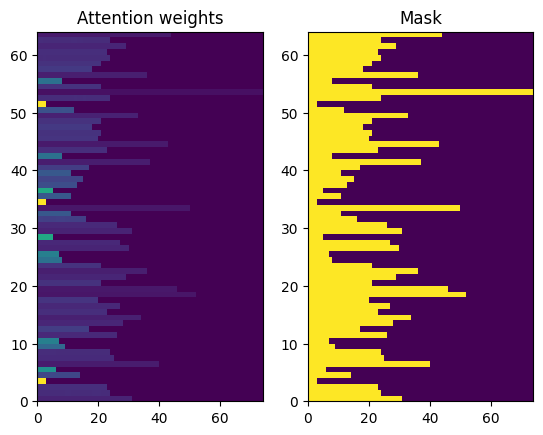

In [ ]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');

In [ ]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


 
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)


    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

 
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [ ]:
@Decoder.add_method
def call(self,
         context, x,
         state = None,
         return_state = False):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch t')
    shape_checker(context, 'batch s units')
    
    # 1. Lookup the embeddings
    x = self.embedding(x)
    shape_checker(x, 'batch t units')
    
    x, state = self.rnn(x, initial_state=state)
    shape_checker(x, 'batch t units')
    
    x = self.attention(x, context)
    self.last_attention_weights = self.attention.last_attention_weights
    shape_checker(x, 'batch t units')
    
    x = self.attention(x, context)
    self.last_attention_weights = self.attention.last_attention_weights
    shape_checker(x, 'batch t units')
    shape_checker(self.last_attention_weights, 'batch t s')
    
    logits = self.output_layer(x)
    shape_checker(logits, 'batch t target_vocab_size')
    
    if return_state:
        return logits, state
    else:
        return logits

In [ ]:
decoder = Decoder(target_text_processor, UNITS)

In [ ]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 74, 256)
input target tokens shape: (batch, t) (64, 49)
logits shape shape: (batch, target_vocabulary_size) (64, 49, 10000)


In [ ]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [ ]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [ ]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 

  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

  return next_token, done, state

In [ ]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'ism restrict flavors ctel hung accession dried exhibit markham poorest',
       b'essentially tribunal leaves temperate filets euromonitor medicine lasting avocados explorers',
       b'fruits closing poland grey decline note wanted instituto fines tissueinformatics'],
      dtype=object)

In [ ]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [ ]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 74)
Target tokens, shape: (batch, t) (64, 49)
logits, shape: (batch, t, target_vocabulary_size) (64, 49, 10000)


In [ ]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [ ]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

In [ ]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 9.2103405, 'expected_acc': 0.0001}

In [ ]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 9s 61ms/step - loss: 9.2209 - masked_acc: 7.5731e-05 - masked_loss: 9.2209


{'loss': 9.220905303955078,
 'masked_acc': 7.573133188998327e-05,
 'masked_loss': 9.220905303955078}

In [ ]:
history = model.fit(
    train_ds.repeat(), 
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100
100/100 [==============================] - 54s 380ms/step - loss: 6.2604 - masked_acc: 0.1446 - masked_loss: 6.2604 - val_loss: 5.4795 - val_masked_acc: 0.2076 - val_masked_loss: 5.4795
Epoch 2/100
100/100 [==============================] - 27s 264ms/step - loss: 5.3696 - masked_acc: 0.2231 - masked_loss: 5.3696 - val_loss: 5.1015 - val_masked_acc: 0.2432 - val_masked_loss: 5.1015
Epoch 3/100
100/100 [==============================] - 20s 203ms/step - loss: 5.0047 - masked_acc: 0.2469 - masked_loss: 5.0047 - val_loss: 4.7986 - val_masked_acc: 0.2607 - val_masked_loss: 4.7986
Epoch 4/100
100/100 [==============================] - 18s 181ms/step - loss: 4.7387 - masked_acc: 0.2666 - masked_loss: 4.7387 - val_loss: 4.5861 - val_masked_acc: 0.2793 - val_masked_loss: 4.5861
Epoch 5/100
100/100 [==============================] - 14s 141ms/step - loss: 4.5168 - masked_acc: 0.2888 - masked_loss: 4.5168 - val_loss: 4.3622 - val_masked_acc: 0.3008 - val_masked_loss: 4.3622
Epoch 6/10

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


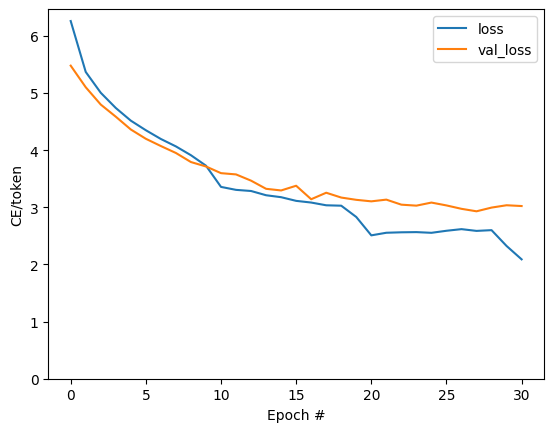

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

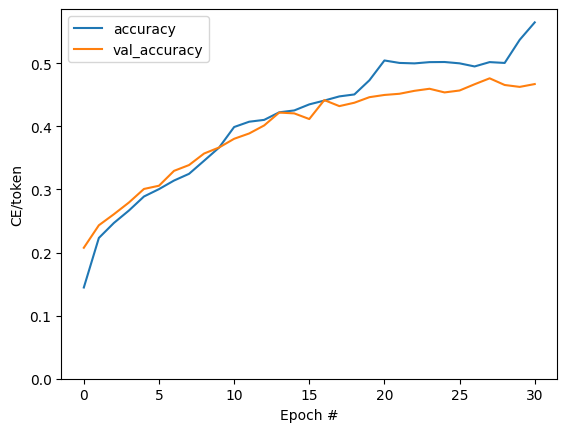

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [ ]:
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)

    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [82]:
result = model.translate(["Pardon, excusez-moi"]) # What is your name
result[0].numpy().decode()

'[UNK] , [UNK] '